Parsed 8 images from the PDF file


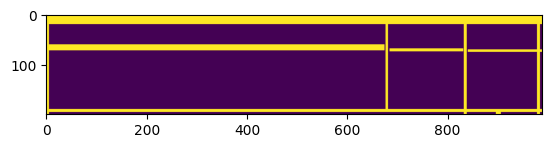

In [ ]:
import numpy as np
from shapely.geometry import LineString, MultiLineString
from shapely.ops import polygonize, unary_union
from table_detection.table_detection import core_line_detection, find_table_bounding_boxes
from table_detection.table_detection import detect_table_from_image_data, find_clusters_1d 
from test_tables import parse_images
import numpy as np
from matplotlib import pyplot as plt
import cv2

def find_clusters_1d_arrays(
    lines_data , gap_threshold: float, min_cluster_size: int = 1, axis: int = 0
):
    """
    Finds clusters in a 1D list of numbers based on a simple
    gap threshold.

    Args:
        data: A list oflines list.
        gap_threshold: The maximum gap to allow *inside* a cluster.
        min_cluster_size: The minimum number of items to be
                          considered a "real" cluster.
        axis,: clustering axis, 0 for X axis and 1 for Y axis

    Returns:
        A dictionary where keys are cluster IDs (0, 1, 2...)
        and values are the lists of numbers in that cluster.
    """
    
    data = [line[axis] for line in lines_data]
    if not data:
        return {}

    # Step 1: Sort the data
    data.sort()

    clusters = {}
    current_cluster_id = 0
    current_cluster = [lines_data[0]]

    # Step 2 & 3: Iterate and find gaps
    for i in range(len(data) - 1):
        # Calculate the gap
        gap = data[i + 1] - data[i]

        if gap > gap_threshold:
            # "Break" - end the current cluster and start a new one
            clusters[current_cluster_id] = current_cluster
            current_cluster_id += 1
            current_cluster = [lines_data[i + 1]]
        else:
            # "No break" - add to the current cluster
            current_cluster.append(lines_data[i + 1])

    # Add the last cluster
    clusters[current_cluster_id] = current_cluster
    final_clusters = clusters

    return final_clusters

def display_lines(lines, image):
    # Create new image with combined grids
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for line in lines:
        cv2.rectangle(mask, (round(line[0]), round(line[1])) , (round(line[2]), round(line[3])) ,255,-1)
        
    return mask


pdf_path = "/Users/nabiltchoulak/code/ocr-recognition/data_test/F1962008.pdf"
images = parse_images(pdf_path)


page_image_rgb = np.array(images[0])
table_boxes, img_grid = detect_table_from_image_data(page_image_rgb)

extended_lines = []
image = np.array(page_image_rgb)
table_bbox = table_boxes[0]


table_x_start = table_bbox[0]
table_y_start = table_bbox[1]
table_x_end = table_bbox[0] + table_bbox[2]
table_y_end = table_bbox[1] + table_bbox[3]
left_line = (0, 0, 5, table_bbox[3])
top_line = (0, 0, table_bbox[2], 5)
right_line = (table_bbox[2] - 10, 0, 5, table_bbox[3])
bottom_line = (0, table_bbox[3] - 10, table_bbox[2], 5)



np_img = np.array(image)
# Do the processing only inside the table
np_img_cropped = np_img[
    table_y_start:table_y_end,
    table_x_start:table_x_end,
    :,
]
extension_amount=15.0

combined_grid, contours_v, contours_h = core_line_detection(np_img_cropped, 3, 10)

vertical_lines = [cv2.boundingRect(cnt) for cnt in contours_v]

horizontal_lines = [cv2.boundingRect(cnt) for cnt in contours_h]

vertical_lines.sort(key=lambda c: c[0])
horizontal_lines.sort(key=lambda c: c[1])


# Add all surrounding lines
vertical_lines.insert(0, left_line)
horizontal_lines.insert(0, top_line)
vertical_lines.insert(-1, right_line)
horizontal_lines.insert(-1, bottom_line)

lines = [(line[0], line[1], line[0] + line[2], line[1] + line[3]) for line in [*vertical_lines, *horizontal_lines]]

lines_img = display_lines(lines,np_img_cropped)

plt.imshow(lines_img)
plt.show()

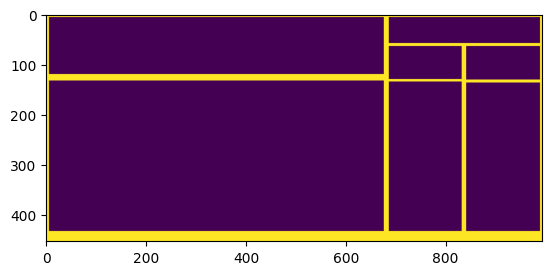

In [2]:
def remove_line_duplicates(line_clusters, axis):
    secondary_axis = (axis + 1) % 2
    for cluster_key in line_clusters.keys():
        
        prev_line  = line_clusters[cluster_key][0]
        filtered_lines = [line_clusters[cluster_key][0]]
        for line in line_clusters[cluster_key]:
            # Only remove lines that have the same starting point
            if abs(line[secondary_axis] - prev_line[secondary_axis]) > 10:
                filtered_lines.append(line)
                
            prev_line = line
        line_clusters[cluster_key] = filtered_lines
        
# Remove duplicate lines:
# TODO: modify find clusters by adding line dimension
vertical_clusters = find_clusters_1d_arrays(vertical_lines, 0.05*table_bbox[3])        
horizontal_clusters = find_clusters_1d_arrays(horizontal_lines, 0.05*table_bbox[2], 1, 1)

remove_line_duplicates(vertical_clusters, 0)
remove_line_duplicates(horizontal_clusters, 1)
    

new_lines = [(line[0][0], line[0][1], line[0][0] + line[0][2], line[0][1] + line[0][3]) for _,line in vertical_clusters.items()]

for _, lines in horizontal_clusters.items():
    for line in lines:
        new_lines.append((line[0], line[1], line[0] + line[2], line[1] + line[3]))

new_lines_img = display_lines(new_lines,np_img_cropped)

# 1. Combine the horizontal and vertical line images
# table_grid = cv2.bitwise_or(morphed_horizontal, morphed_vertical)

# 2. Morphological Close ("Smear" the lines together)
# This is the most important parameter to tune.
# (15, 15) means it will connect lines that are up to 15px apart.
kernel_size = (25, 25)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

# "Closing" = Dilate (thicken) then Erode (thin)
# This fills gaps and connects nearby lines.
closed_grid = cv2.morphologyEx(new_lines_img, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed_grid)
plt.show()

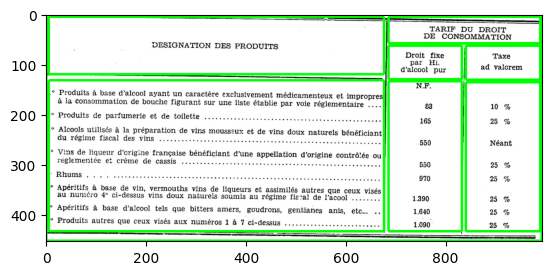

In [4]:
contours, hierarchy = cv2.findContours(
        closed_grid, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
table_bounding_boxes = []
for cnt in contours:
    # 4. Get the bounding box for each blob
    bbox = cv2.boundingRect(cnt)
    if bbox[2] < table_bbox[2]*0.9 or bbox[3] < table_bbox[3] * 0.95:
        bbox[0] += table_bbox[0]
        bbox[1] += table_bbox[1]
        table_bounding_boxes.append(bbox)


In [ ]:
for v_line in [*vertical_lines, *horizontal_lines]:
    p1 = np.array(v_line[0:2])
    p2 = np.array((v_line[0] + v_line[2], v_line[1] + v_line[3]))
    
    # Vector direction
    direction = p2 - p1
    length = np.linalg.norm(direction)
    
    if length == 0: continue # Skip zero-length lines
        
    unit_vector = direction / length
    
    # Extend both ends
    p1_new = p1 - unit_vector * extension_amount
    p2_new = p2 + unit_vector * extension_amount
    extended_lines.append(LineString([p1_new, p2_new]))


# 2. Node the lines (create intersections)
# unary_union takes all lines and splits them wherever they cross.
# This turns a "grid" of long lines into a graph of small segments.
noded_lines = unary_union(MultiLineString(extended_lines))

# 3. Polygonize
# This magic function finds all closed loops (faces) in the planar graph
polygons = list(polygonize(noded_lines))

# 4. Extract Bounding Boxes
results = []
for poly in polygons:
    # poly.bounds returns (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = poly.bounds
    results.append(
        (minx, miny, maxx, maxy) # specific shape if needed
    )
cells_bbox_list = [
    bbox
    for bbox in results
    if ((bbox[2] - bbox[0]) / table_bbox[2] > 0.05 and (bbox[3] - bbox[1]) / table_bbox[3] > 0.05)
]
for x, y, x2, y2 in cells_bbox_list:
    cv2.rectangle(np_img_cropped, (round(x), round(y)), (round(x2), round(y2)), (0, 0, 255), 3)
plt.imshow(lines_img)
plt.show()

## Old cell definition approach (with loops)

In [ ]:
from table_detection.table_detection import core_line_detection, find_table_bounding_boxes

"""
if (not(current_x < (horizontal_lines[v_index][0] + vertical[2]/2) < current_x + current_width) 
                and ((v_index + i) < len(horizontal_lines))):
                print(v_index + i, horizontal_lines[v_index + i][0])
                while (not(current_x < horizontal_lines[v_index + i][0] + vertical[2]/2 < current_x + current_width)):
                    i+=1
                    if ((v_index + i) >= len(horizontal_lines)):
                        i=0
                        break
"""

image = np.array(pil_page_image)
table_bbox = [x, y, w, h]

def check_line_cell_border(
    cell_origin, vertical_line_bbox, tolerance, axis_index=0
):
    # 0 axis is the X axis (horizontal axis in the array)
    if axis_index == 0:
        return abs(cell_origin[1] - vertical_line_bbox[1]) > tolerance
    # 1 axis is the Y axis (vertical axis in the array)
    if axis_index == 1:
        return abs(cell_origin[0] - vertical_line_bbox[0]) > tolerance

table_x_start = table_bbox[0]
table_y_start = table_bbox[1]
table_x_end = table_bbox[0] + table_bbox[2]
table_y_end = table_bbox[1] + table_bbox[3]
left_line = (0, 0, 0, table_bbox[3])
top_line = (0, 0, table_bbox[2], 0)
right_line = (table_x_end, 0, 0, table_bbox[3])
bottom_line = (0, table_y_end, table_bbox[2], 0)
np_img = np.array(image)
# Do the processing only inside the table
np_img_cropped = np_img[
    table_y_start:table_y_end,
    table_x_start:table_x_end,
    :,
]

combined_grid, contours_v, contours_h = core_line_detection(np_img_cropped, 3, 10)

vertical_lines = [cv2.boundingRect(cnt) for cnt in contours_v]

horizontal_lines = [cv2.boundingRect(cnt) for cnt in contours_h]

# Add all surrounding lines
vertical_lines.insert(0, left_line)
horizontal_lines.insert(0, top_line)
vertical_lines.insert(-1, right_line)
horizontal_lines.insert(-1, bottom_line)

vertical_lines.sort(key=lambda c: c[0])
horizontal_lines.sort(key=lambda c: c[1])

cells_bbox_list = []

current_y = horizontal_lines[0][1]
v_iterator = iter(enumerate(horizontal_lines))
h_index = 0
v_index = 0

while (current_x / table_x_end < 0.95) and (current_y / table_y_end < 0.95):
    print(h_index, v_index)
    #print(current_x / table_x_end, current_y / table_y_end)
    # find the next vertical line that defines this cell
    next_vertical_line_idx, next_vertical_line = next(
        (
            (index, vertical)
            for index, vertical in enumerate(vertical_lines[h_index:])
            if check_line_cell_border((current_x, current_y), vertical, 5, 0)
        ),
        ((len(vertical_lines) - 1), right_line),
    )

    next_horizontal_line_idx, next_horizontal_line = next(
        (
            (index, horizontal)
            for index, horizontal in enumerate(horizontal_lines[v_index:])
            if check_line_cell_border((current_x, current_y), horizontal, 5, 1)
        ),
        ((len(horizontal_lines) - 1), bottom_line),
    )

    current_height = next_horizontal_line[1] - current_y
    current_width = next_vertical_line[0] - current_x
    print(f"BBox inserted: {[current_x, current_y, current_width, current_height]}")
    cells_bbox_list.append([current_x, current_y, current_width, current_height])

    # Next horizontal index (for vertical lines) needs to be aligned with the current
    # cell right border
    h_index = next_vertical_line_idx % (len(vertical_lines) - 1)
    current_x = vertical_lines[0][h_index]

    if h_index == 0:
        v_index, current_horizontal = next(
            v_iterator, ((len(horizontal_lines) - 1), bottom_line)
        )
        print(f" Went into next horizontal line: {v_index, current_horizontal}")
        current_y = current_horizontal[1]

cells_bbox_list = [
    bbox
    for bbox in cells_bbox_list
    if (bbox[2] / table_bbox[2] > 0.05 and bbox[3] / table_bbox[3] > 0.05)
]
print(cells_bbox_list)
for x, y, w, h in cells_bbox_list:
    cv2.rectangle(np_img_cropped, (x, y), (x + w, y + h), (0, 0, 255), 3)
plt.imshow(np_img_cropped)
plt.show()


## Test full approach

Parsed 8 images from the PDF file


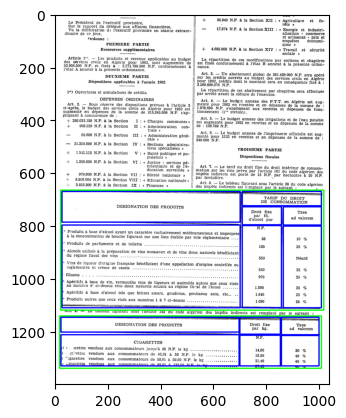

In [ ]:
import numpy as np
from shapely.geometry import LineString, MultiLineString
from shapely.ops import polygonize, unary_union
from table_detection.table_detection import core_line_detection, find_table_bounding_boxes
from table_detection.table_detection import detect_table_from_image_data, find_clusters_1d
from test_tables import parse_images
import numpy as np
from matplotlib import pyplot as plt
import cv2


def find_clusters_1d_arrays(
    lines_data, gap_threshold: float, min_cluster_size: int = 1, axis: int = 0
):
    """
    Finds clusters in a 1D list of numbers based on a simple
    gap threshold.

    Args:
        data: A list oflines list.
        gap_threshold: The maximum gap to allow *inside* a cluster.
        min_cluster_size: The minimum number of items to be
                          considered a "real" cluster.
        axis,: clustering axis, 0 for X axis and 1 for Y axis

    Returns:
        A dictionary where keys are cluster IDs (0, 1, 2...)
        and values are the lists of numbers in that cluster.
    """

    data = [line[axis] for line in lines_data]
    if not data:
        return {}

    # Step 1: Sort the data
    data.sort()

    clusters = {}
    current_cluster_id = 0
    current_cluster = [lines_data[0]]

    # Step 2 & 3: Iterate and find gaps
    for i in range(len(data) - 1):
        # Calculate the gap
        gap = data[i + 1] - data[i]

        if gap > gap_threshold:
            # "Break" - end the current cluster and start a new one
            clusters[current_cluster_id] = current_cluster
            current_cluster_id += 1
            current_cluster = [lines_data[i + 1]]
        else:
            # "No break" - add to the current cluster
            current_cluster.append(lines_data[i + 1])

    # Add the last cluster
    clusters[current_cluster_id] = current_cluster
    final_clusters = clusters

    return final_clusters


def display_lines(lines, image):
    # Create new image with combined grids
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for line in lines:
        cv2.rectangle(
            mask,
            (round(line[0]), round(line[1])),
            (round(line[2]), round(line[3])),
            255,
            -1,
        )

    return mask


def detect_table_cells(image, table_bbox):
    table_x_start = table_bbox[0]
    table_y_start = table_bbox[1]
    table_x_end = table_bbox[0] + table_bbox[2]
    table_y_end = table_bbox[1] + table_bbox[3]
    left_line = (0, 0, 5, table_bbox[3])
    top_line = (0, 0, table_bbox[2], 5)
    right_line = (table_bbox[2] - 10, 0, 5, table_bbox[3])
    bottom_line = (0, table_bbox[3] - 10, table_bbox[2], 5)

    np_img = np.array(image)
    # Do the processing only inside the table
    np_img_cropped = np_img[
        table_y_start:table_y_end,
        table_x_start:table_x_end,
        :,
    ]

    combined_grid, contours_v, contours_h = core_line_detection(np_img_cropped, 3, 10)

    vertical_lines = [cv2.boundingRect(cnt) for cnt in contours_v]

    horizontal_lines = [cv2.boundingRect(cnt) for cnt in contours_h]

    vertical_lines.sort(key=lambda c: c[0])
    horizontal_lines.sort(key=lambda c: c[1])

    # Add all surrounding lines
    vertical_lines.insert(0, left_line)
    horizontal_lines.insert(0, top_line)
    vertical_lines.insert(-1, right_line)
    horizontal_lines.insert(-1, bottom_line)

    ## Step 2

    def remove_line_duplicates(line_clusters, axis):
        secondary_axis = (axis + 1) % 2
        for cluster_key in line_clusters.keys():

            prev_line = line_clusters[cluster_key][0]
            filtered_lines = [line_clusters[cluster_key][0]]
            for line in line_clusters[cluster_key]:
                # Only remove lines that have the same starting point
                if abs(line[secondary_axis] - prev_line[secondary_axis]) > 10:
                    filtered_lines.append(line)

                prev_line = line
            line_clusters[cluster_key] = filtered_lines

    # Remove duplicate lines:
    vertical_clusters = find_clusters_1d_arrays(vertical_lines, 0.05 * table_bbox[3])
    horizontal_clusters = find_clusters_1d_arrays(
        horizontal_lines, 0.05 * table_bbox[2], 1, 1
    )

    remove_line_duplicates(vertical_clusters, 0)
    remove_line_duplicates(horizontal_clusters, 1)

    new_lines = [
        (line[0][0], line[0][1], line[0][0] + line[0][2], line[0][1] + line[0][3])
        for _, line in vertical_clusters.items()
    ]

    for _, lines in horizontal_clusters.items():
        for line in lines:
            new_lines.append((line[0], line[1], line[0] + line[2], line[1] + line[3]))

    new_lines_img = display_lines(new_lines, np_img_cropped)

    # 1. Combine the horizontal and vertical line images
    # table_grid = cv2.bitwise_or(morphed_horizontal, morphed_vertical)

    # 2. Morphological Close ("Smear" the lines together)
    # This is the most important parameter to tune.
    # (15, 15) means it will connect lines that are up to 15px apart.
    kernel_size = (25, 25)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # "Closing" = Dilate (thicken) then Erode (thin)
    # This fills gaps and connects nearby lines.
    closed_grid = cv2.morphologyEx(new_lines_img, cv2.MORPH_CLOSE, kernel)

    contours, hierarchy = cv2.findContours(
        closed_grid, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
    table_bounding_boxes = []
    for cnt in contours:
        # 4. Get the bounding box for each blob
        bbox = cv2.boundingRect(cnt)
        if bbox[2] < table_bbox[2] * 0.9 or bbox[3] < table_bbox[3] * 0.95:
            table_bounding_boxes.append(
                [bbox[0] + table_bbox[0], bbox[1] + table_bbox[1], bbox[2], bbox[3]]
            )
    return table_bounding_boxes


pdf_path = "/Users/nabiltchoulak/code/ocr-recognition/data_test/F1962008.pdf"
images = parse_images(pdf_path)


page_image_rgb = np.array(images[0])
table_boxes, img_grid = detect_table_from_image_data(page_image_rgb)

image = np.array(page_image_rgb)
for table in table_boxes:
    cv2.rectangle(
            page_image_rgb,
            (table[0], table[1]),
            (table[0] + table[2], table[1] + table[3]),
            (0, 255, 0),
            3,
        )
    table_bboxes = detect_table_cells(image, table)
    for cell in table_bboxes:
        cv2.rectangle(
            page_image_rgb,
            (cell[0], cell[1]),
            (cell[0] + cell[2], cell[1] + cell[3]),
            (0, 0, 255),
            3,
        )

plt.imshow(page_image_rgb)
plt.show()